# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

import helper
 
helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:12<00:00, 4.75KFile/s]


Extracting celeba...


In [2]:


#!pip install --upgrade --force-reinstall matplotlib==2.0.0
!pip install --upgrade --force-reinstall tqdm==4.11.2
#!pip install --upgrade numpy
from google.colab import files
files.upload()
import helper
import problem_unittests
# choose the file on your computer to upload it then


    100% |████████████████████████████████| 51kB 2.0MB/s 


Saving helper.py to helper.py
Saving problem_unittests.py to problem_unittests.py


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

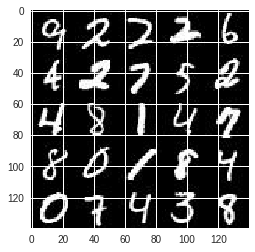

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import numpy as np

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(np.array(helper.images_square_grid(mnist_images, 'L')), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

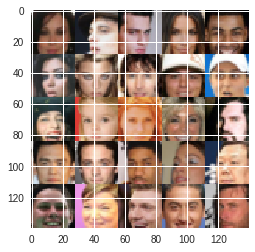

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real=tf.placeholder(tf.float32,[None,image_width,image_height,image_channels],name="input_real")
    inputs_z=tf.placeholder(tf.float32,[None,z_dim],name="input_z")
    learning_rate=tf.placeholder(tf.float32,[],name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope("discriminator",reuse=reuse):
        x1=tf.layers.conv2d(images,64,5, strides=2,padding="same")
        x1=tf.maximum(x1*alpha,x1)
        #layer2
        x2=tf.layers.conv2d(x1,128,5 ,strides=2,padding="same")
        x2=tf.layers.batch_normalization(x2, training=True)
        x2=tf.maximum(x2*alpha,x2)

        #layer3
        x3=tf.layers.conv2d(x2,256,5 ,strides=2,padding="same")
        x3=tf.layers.batch_normalization(x3, training=True)
        x3=tf.maximum(x3*alpha,x3)

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)



    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse=not (is_train)):
        
        x1=tf.layers.dense(z,7*7*512)
        x1=tf.reshape(x1,[-1,7,7,512])
        x1= tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(alpha * x1, x1)
        #conv1
        x2=tf.layers.conv2d_transpose(x1,265,5,strides=2,padding='same')
        x2= tf.layers.batch_normalization(x2, training=True)
        x2= tf.maximum(alpha * x2, x2)
        

        #output layer
        logits=tf.layers.conv2d_transpose(x2,out_channel_dim,5,strides=2,padding='same')
        
        out=tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model=generator(input_z, out_channel_dim, is_train=True)
    d_real_out,d_real_logits=discriminator(input_real, reuse=False)
    d_fake_out,d_fake_logits=discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=tf.ones_like(d_real_out )* (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_out)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_out)))

    d_loss = d_loss_real + d_loss_fake
    
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(np.array(images_grid), cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    input_real,input_z,lr=model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss,g_loss=model_loss(input_real, input_z, data_shape[3])
    d_train_opt,g_train_opt=model_opt(d_loss, g_loss, learning_rate, beta1)
    steps=0
    losses =[]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images*=2
                steps+=1
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))   
    
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z,lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,input_real: batch_images,lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 12, input_z, data_shape[3], data_image_mode)
# Save training generator samples
#with open('train_samples.pkl', 'wb') as f:
    #pkl.dump(samples, f)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7116... Generator Loss: 6.3872
Epoch 1/2... Discriminator Loss: 0.3758... Generator Loss: 3.9263
Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 4.0026
Epoch 1/2... Discriminator Loss: 0.7409... Generator Loss: 2.1007
Epoch 1/2... Discriminator Loss: 1.1043... Generator Loss: 1.0784
Epoch 1/2... Discriminator Loss: 1.8404... Generator Loss: 0.3283
Epoch 1/2... Discriminator Loss: 1.3875... Generator Loss: 0.6497
Epoch 1/2... Discriminator Loss: 1.3170... Generator Loss: 1.7740
Epoch 1/2... Discriminator Loss: 1.1072... Generator Loss: 1.0717
Epoch 1/2... Discriminator Loss: 0.9568... Generator Loss: 1.2337


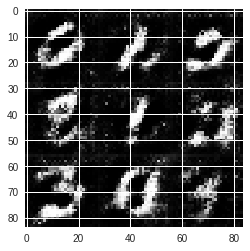

Epoch 1/2... Discriminator Loss: 1.2672... Generator Loss: 0.6335
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 0.7717
Epoch 1/2... Discriminator Loss: 1.2011... Generator Loss: 0.8595
Epoch 1/2... Discriminator Loss: 1.0599... Generator Loss: 1.0593
Epoch 1/2... Discriminator Loss: 1.0881... Generator Loss: 1.1859
Epoch 1/2... Discriminator Loss: 1.0889... Generator Loss: 0.8296
Epoch 1/2... Discriminator Loss: 1.0143... Generator Loss: 0.9032
Epoch 1/2... Discriminator Loss: 1.0791... Generator Loss: 0.9574
Epoch 1/2... Discriminator Loss: 1.1505... Generator Loss: 0.8352
Epoch 1/2... Discriminator Loss: 1.2578... Generator Loss: 0.6057


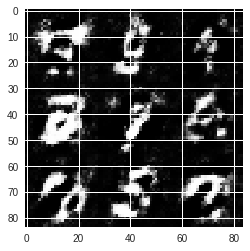

Epoch 1/2... Discriminator Loss: 0.9678... Generator Loss: 1.4581
Epoch 1/2... Discriminator Loss: 1.1975... Generator Loss: 2.0755
Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 0.8049
Epoch 1/2... Discriminator Loss: 1.2348... Generator Loss: 0.6195
Epoch 1/2... Discriminator Loss: 0.8906... Generator Loss: 1.6286
Epoch 1/2... Discriminator Loss: 0.9924... Generator Loss: 1.8791
Epoch 1/2... Discriminator Loss: 0.8940... Generator Loss: 1.6264
Epoch 1/2... Discriminator Loss: 1.1303... Generator Loss: 0.6766
Epoch 1/2... Discriminator Loss: 0.8515... Generator Loss: 1.2675
Epoch 1/2... Discriminator Loss: 0.8749... Generator Loss: 1.1106


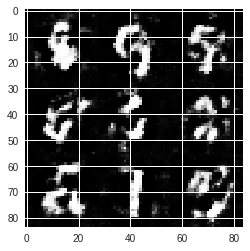

Epoch 1/2... Discriminator Loss: 1.5633... Generator Loss: 0.4302
Epoch 1/2... Discriminator Loss: 0.7824... Generator Loss: 1.6085
Epoch 1/2... Discriminator Loss: 0.7588... Generator Loss: 1.5877
Epoch 1/2... Discriminator Loss: 0.8157... Generator Loss: 1.5602
Epoch 1/2... Discriminator Loss: 0.7502... Generator Loss: 1.8379
Epoch 1/2... Discriminator Loss: 0.8096... Generator Loss: 1.2052
Epoch 1/2... Discriminator Loss: 0.7163... Generator Loss: 1.7073
Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 1.3537
Epoch 1/2... Discriminator Loss: 0.9923... Generator Loss: 0.9425
Epoch 1/2... Discriminator Loss: 0.8444... Generator Loss: 1.8892


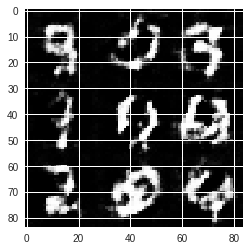

Epoch 1/2... Discriminator Loss: 0.8710... Generator Loss: 1.1028
Epoch 1/2... Discriminator Loss: 1.6060... Generator Loss: 0.4122
Epoch 1/2... Discriminator Loss: 0.8055... Generator Loss: 1.6336
Epoch 1/2... Discriminator Loss: 0.7972... Generator Loss: 1.8602
Epoch 1/2... Discriminator Loss: 0.8410... Generator Loss: 1.4104
Epoch 1/2... Discriminator Loss: 1.6517... Generator Loss: 0.3856
Epoch 1/2... Discriminator Loss: 0.9883... Generator Loss: 0.8403
Epoch 1/2... Discriminator Loss: 1.2029... Generator Loss: 0.6541
Epoch 1/2... Discriminator Loss: 0.9419... Generator Loss: 0.9944
Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 1.2248


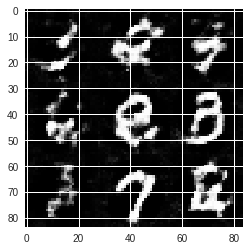

Epoch 1/2... Discriminator Loss: 0.9065... Generator Loss: 1.3046
Epoch 1/2... Discriminator Loss: 1.4120... Generator Loss: 0.5183
Epoch 1/2... Discriminator Loss: 0.8087... Generator Loss: 1.2397
Epoch 1/2... Discriminator Loss: 1.0606... Generator Loss: 0.7871
Epoch 1/2... Discriminator Loss: 0.8590... Generator Loss: 1.9174
Epoch 1/2... Discriminator Loss: 0.8036... Generator Loss: 1.5134
Epoch 1/2... Discriminator Loss: 0.9662... Generator Loss: 2.0510
Epoch 1/2... Discriminator Loss: 0.8699... Generator Loss: 1.5223
Epoch 1/2... Discriminator Loss: 0.8452... Generator Loss: 1.5816
Epoch 1/2... Discriminator Loss: 0.9333... Generator Loss: 1.0191


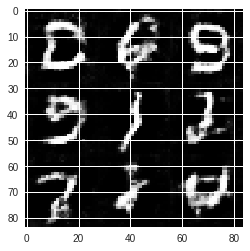

Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 0.8807... Generator Loss: 1.7534
Epoch 1/2... Discriminator Loss: 1.4710... Generator Loss: 0.4755
Epoch 1/2... Discriminator Loss: 0.9885... Generator Loss: 1.2247
Epoch 1/2... Discriminator Loss: 0.8295... Generator Loss: 1.4986
Epoch 1/2... Discriminator Loss: 1.6971... Generator Loss: 0.3866
Epoch 1/2... Discriminator Loss: 1.0274... Generator Loss: 0.8439
Epoch 1/2... Discriminator Loss: 1.0744... Generator Loss: 0.7898
Epoch 1/2... Discriminator Loss: 0.8003... Generator Loss: 1.3585
Epoch 1/2... Discriminator Loss: 0.8696... Generator Loss: 1.1798


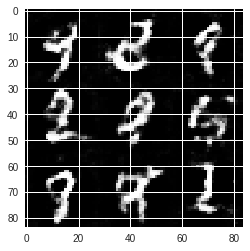

Epoch 1/2... Discriminator Loss: 0.9561... Generator Loss: 0.9253
Epoch 1/2... Discriminator Loss: 0.8753... Generator Loss: 1.0736
Epoch 1/2... Discriminator Loss: 0.8110... Generator Loss: 1.8715
Epoch 1/2... Discriminator Loss: 1.2027... Generator Loss: 0.6440
Epoch 1/2... Discriminator Loss: 0.8189... Generator Loss: 1.7245
Epoch 1/2... Discriminator Loss: 0.8637... Generator Loss: 1.7234
Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 1.0966
Epoch 1/2... Discriminator Loss: 0.8519... Generator Loss: 1.4345
Epoch 1/2... Discriminator Loss: 1.1134... Generator Loss: 0.7803
Epoch 1/2... Discriminator Loss: 0.9013... Generator Loss: 1.7762


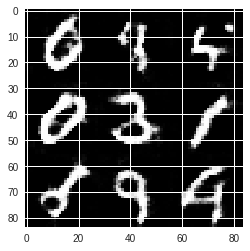

Epoch 1/2... Discriminator Loss: 0.8161... Generator Loss: 1.5436
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 0.7904
Epoch 1/2... Discriminator Loss: 0.7816... Generator Loss: 1.4262
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 0.7963
Epoch 1/2... Discriminator Loss: 0.9407... Generator Loss: 1.0729
Epoch 1/2... Discriminator Loss: 0.9039... Generator Loss: 1.0351
Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 0.5441
Epoch 1/2... Discriminator Loss: 0.9000... Generator Loss: 1.0313
Epoch 1/2... Discriminator Loss: 1.0606... Generator Loss: 2.3612
Epoch 1/2... Discriminator Loss: 1.0581... Generator Loss: 0.7808


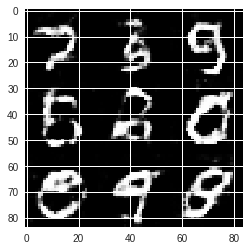

Epoch 1/2... Discriminator Loss: 0.8726... Generator Loss: 1.2620
Epoch 1/2... Discriminator Loss: 0.8560... Generator Loss: 1.7943
Epoch 1/2... Discriminator Loss: 1.1010... Generator Loss: 0.7150
Epoch 2/2... Discriminator Loss: 1.0761... Generator Loss: 0.7977
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.5596
Epoch 2/2... Discriminator Loss: 0.8354... Generator Loss: 1.5862
Epoch 2/2... Discriminator Loss: 0.9599... Generator Loss: 1.0521
Epoch 2/2... Discriminator Loss: 1.1189... Generator Loss: 0.7562
Epoch 2/2... Discriminator Loss: 0.9074... Generator Loss: 1.0599
Epoch 2/2... Discriminator Loss: 1.0924... Generator Loss: 0.7410


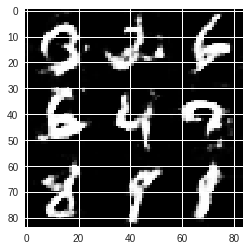

Epoch 2/2... Discriminator Loss: 0.9144... Generator Loss: 0.9733
Epoch 2/2... Discriminator Loss: 0.8297... Generator Loss: 2.0244
Epoch 2/2... Discriminator Loss: 1.1272... Generator Loss: 0.7303
Epoch 2/2... Discriminator Loss: 0.6746... Generator Loss: 1.4696
Epoch 2/2... Discriminator Loss: 0.9300... Generator Loss: 0.9030
Epoch 2/2... Discriminator Loss: 0.9787... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 1.1658... Generator Loss: 0.6797
Epoch 2/2... Discriminator Loss: 0.7915... Generator Loss: 2.2266
Epoch 2/2... Discriminator Loss: 1.3776... Generator Loss: 2.4159
Epoch 2/2... Discriminator Loss: 0.8560... Generator Loss: 1.1217


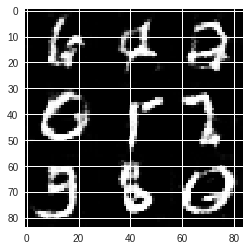

Epoch 2/2... Discriminator Loss: 0.7146... Generator Loss: 1.4514
Epoch 2/2... Discriminator Loss: 0.7327... Generator Loss: 1.3993
Epoch 2/2... Discriminator Loss: 0.7652... Generator Loss: 1.2317
Epoch 2/2... Discriminator Loss: 0.6367... Generator Loss: 1.5940
Epoch 2/2... Discriminator Loss: 0.7255... Generator Loss: 1.4896
Epoch 2/2... Discriminator Loss: 0.7120... Generator Loss: 1.3968
Epoch 2/2... Discriminator Loss: 0.9061... Generator Loss: 0.9720
Epoch 2/2... Discriminator Loss: 0.8329... Generator Loss: 1.1377
Epoch 2/2... Discriminator Loss: 0.7132... Generator Loss: 1.4247
Epoch 2/2... Discriminator Loss: 0.7884... Generator Loss: 1.1881


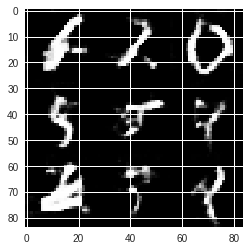

Epoch 2/2... Discriminator Loss: 0.6502... Generator Loss: 1.4998
Epoch 2/2... Discriminator Loss: 0.6320... Generator Loss: 2.0757
Epoch 2/2... Discriminator Loss: 2.8341... Generator Loss: 0.1499
Epoch 2/2... Discriminator Loss: 0.8547... Generator Loss: 1.5662
Epoch 2/2... Discriminator Loss: 0.9434... Generator Loss: 1.0668
Epoch 2/2... Discriminator Loss: 0.8156... Generator Loss: 1.6211
Epoch 2/2... Discriminator Loss: 0.7438... Generator Loss: 1.3494
Epoch 2/2... Discriminator Loss: 0.8082... Generator Loss: 1.2509
Epoch 2/2... Discriminator Loss: 0.7612... Generator Loss: 1.6851
Epoch 2/2... Discriminator Loss: 0.8865... Generator Loss: 1.0096


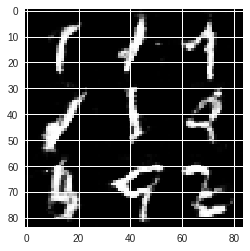

Epoch 2/2... Discriminator Loss: 0.7707... Generator Loss: 1.3029
Epoch 2/2... Discriminator Loss: 0.7529... Generator Loss: 1.2200
Epoch 2/2... Discriminator Loss: 0.8186... Generator Loss: 1.0576
Epoch 2/2... Discriminator Loss: 0.8471... Generator Loss: 1.0294
Epoch 2/2... Discriminator Loss: 1.1498... Generator Loss: 1.8970
Epoch 2/2... Discriminator Loss: 0.8045... Generator Loss: 1.2298
Epoch 2/2... Discriminator Loss: 0.8727... Generator Loss: 1.7216
Epoch 2/2... Discriminator Loss: 0.6858... Generator Loss: 1.4916
Epoch 2/2... Discriminator Loss: 1.1030... Generator Loss: 0.7253
Epoch 2/2... Discriminator Loss: 0.7236... Generator Loss: 2.1466


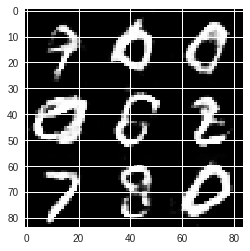

Epoch 2/2... Discriminator Loss: 0.7164... Generator Loss: 1.3940
Epoch 2/2... Discriminator Loss: 0.7499... Generator Loss: 1.2089
Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 1.1745
Epoch 2/2... Discriminator Loss: 0.9345... Generator Loss: 0.9622
Epoch 2/2... Discriminator Loss: 0.6852... Generator Loss: 1.4658
Epoch 2/2... Discriminator Loss: 0.6909... Generator Loss: 1.4089
Epoch 2/2... Discriminator Loss: 0.7822... Generator Loss: 1.1761
Epoch 2/2... Discriminator Loss: 0.7912... Generator Loss: 1.1947
Epoch 2/2... Discriminator Loss: 1.9395... Generator Loss: 0.3335
Epoch 2/2... Discriminator Loss: 0.8543... Generator Loss: 2.0249


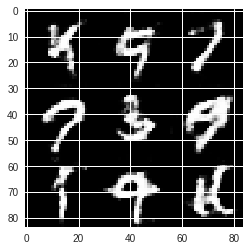

Epoch 2/2... Discriminator Loss: 0.6595... Generator Loss: 1.6669
Epoch 2/2... Discriminator Loss: 0.7732... Generator Loss: 1.1873
Epoch 2/2... Discriminator Loss: 0.7705... Generator Loss: 1.1929
Epoch 2/2... Discriminator Loss: 0.7285... Generator Loss: 1.3509
Epoch 2/2... Discriminator Loss: 1.1947... Generator Loss: 0.6397
Epoch 2/2... Discriminator Loss: 0.9505... Generator Loss: 0.9331
Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 2.1477
Epoch 2/2... Discriminator Loss: 0.7003... Generator Loss: 1.7160
Epoch 2/2... Discriminator Loss: 0.7794... Generator Loss: 1.9837
Epoch 2/2... Discriminator Loss: 0.7437... Generator Loss: 1.2554


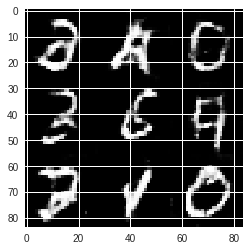

Epoch 2/2... Discriminator Loss: 0.7841... Generator Loss: 3.0036
Epoch 2/2... Discriminator Loss: 0.6410... Generator Loss: 1.6105
Epoch 2/2... Discriminator Loss: 0.7638... Generator Loss: 1.3354
Epoch 2/2... Discriminator Loss: 0.9537... Generator Loss: 0.9172
Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 1.1619
Epoch 2/2... Discriminator Loss: 0.6101... Generator Loss: 1.6375
Epoch 2/2... Discriminator Loss: 0.6920... Generator Loss: 1.4438
Epoch 2/2... Discriminator Loss: 0.6054... Generator Loss: 2.2923
Epoch 2/2... Discriminator Loss: 1.7347... Generator Loss: 0.5292
Epoch 2/2... Discriminator Loss: 1.0141... Generator Loss: 0.8765


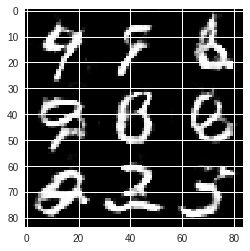

Epoch 2/2... Discriminator Loss: 0.8249... Generator Loss: 1.2244
Epoch 2/2... Discriminator Loss: 0.8147... Generator Loss: 1.1628
Epoch 2/2... Discriminator Loss: 0.9010... Generator Loss: 1.0365
Epoch 2/2... Discriminator Loss: 1.0163... Generator Loss: 0.8594
Epoch 2/2... Discriminator Loss: 0.8009... Generator Loss: 1.2289
Epoch 2/2... Discriminator Loss: 0.8427... Generator Loss: 1.0388
Epoch 2/2... Discriminator Loss: 0.6593... Generator Loss: 1.5302
Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 1.0363
Epoch 2/2... Discriminator Loss: 0.6870... Generator Loss: 1.4935
Epoch 2/2... Discriminator Loss: 0.5711... Generator Loss: 2.0061


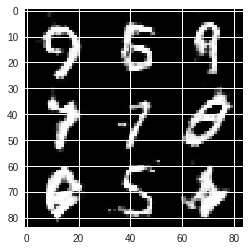

Epoch 2/2... Discriminator Loss: 0.5970... Generator Loss: 1.7377
Epoch 2/2... Discriminator Loss: 1.5618... Generator Loss: 0.4412
Epoch 2/2... Discriminator Loss: 0.7267... Generator Loss: 1.6404
Epoch 2/2... Discriminator Loss: 0.7117... Generator Loss: 2.0101
Epoch 2/2... Discriminator Loss: 0.7142... Generator Loss: 1.5323
Epoch 2/2... Discriminator Loss: 0.9617... Generator Loss: 0.9080
Epoch 2/2... Discriminator Loss: 1.0739... Generator Loss: 0.8017


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 1.8516
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.2521
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 6.2377
Epoch 1/1... Discriminator Loss: 2.1398... Generator Loss: 0.2386
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 1.8198... Generator Loss: 0.3677
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 1.2990
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.6722... Generator Loss: 1.7078


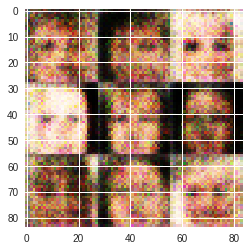

Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 1.9318
Epoch 1/1... Discriminator Loss: 2.4315... Generator Loss: 0.1539
Epoch 1/1... Discriminator Loss: 1.5506... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.0884
Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 2.5126
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.8663
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 3.8803
Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 1.9183


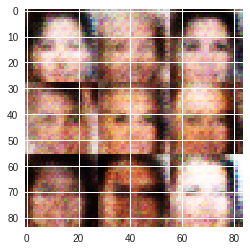

Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 1.6137
Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 1.2989
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 1.6058
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 1.4295
Epoch 1/1... Discriminator Loss: 0.6407... Generator Loss: 1.7147
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.5634


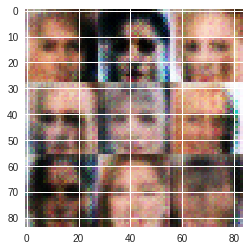

Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 1.4358
Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 1.7093
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 2.0178
Epoch 1/1... Discriminator Loss: 0.7969... Generator Loss: 1.7853
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 2.4810
Epoch 1/1... Discriminator Loss: 1.6817... Generator Loss: 0.3985
Epoch 1/1... Discriminator Loss: 1.6620... Generator Loss: 0.3724
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.4655


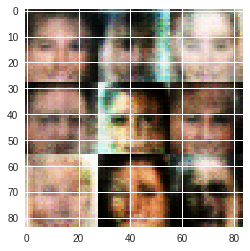

Epoch 1/1... Discriminator Loss: 1.7726... Generator Loss: 0.3489
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 2.8791
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.2859
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.6054... Generator Loss: 2.6849
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.3159
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 2.2099... Generator Loss: 0.2105
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 1.6644
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 1.6709


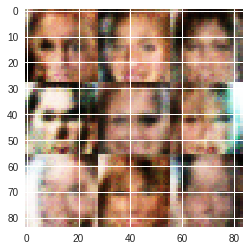

Epoch 1/1... Discriminator Loss: 2.1055... Generator Loss: 0.2426
Epoch 1/1... Discriminator Loss: 1.9780... Generator Loss: 0.2527
Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 4.6129
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 2.1705
Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 3.2372
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 1.2636
Epoch 1/1... Discriminator Loss: 0.8950... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 1.2763
Epoch 1/1... Discriminator Loss: 1.8343... Generator Loss: 5.8017
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 1.4764


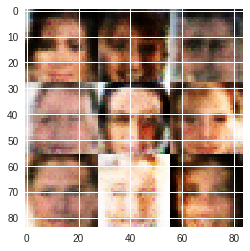

Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 3.0169
Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 1.0878
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 5.4428
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.4089
Epoch 1/1... Discriminator Loss: 0.5647... Generator Loss: 2.8345
Epoch 1/1... Discriminator Loss: 0.6935... Generator Loss: 3.8323
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 2.3700
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 6.2441


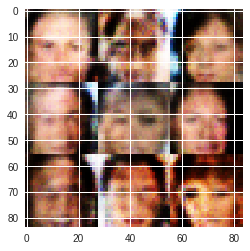

Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 3.5644
Epoch 1/1... Discriminator Loss: 0.4886... Generator Loss: 2.1514
Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 3.5665
Epoch 1/1... Discriminator Loss: 0.4313... Generator Loss: 2.8099
Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 5.1432
Epoch 1/1... Discriminator Loss: 0.5017... Generator Loss: 3.1010
Epoch 1/1... Discriminator Loss: 0.3927... Generator Loss: 5.6812
Epoch 1/1... Discriminator Loss: 0.3446... Generator Loss: 6.0361
Epoch 1/1... Discriminator Loss: 0.6712... Generator Loss: 6.6374
Epoch 1/1... Discriminator Loss: 0.3534... Generator Loss: 4.5885


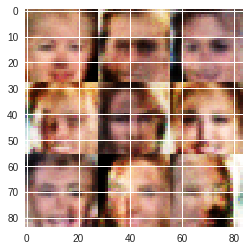

Epoch 1/1... Discriminator Loss: 0.5764... Generator Loss: 5.0820
Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 6.6376
Epoch 1/1... Discriminator Loss: 0.6588... Generator Loss: 1.5060
Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 5.0642
Epoch 1/1... Discriminator Loss: 0.3591... Generator Loss: 4.2511
Epoch 1/1... Discriminator Loss: 0.4717... Generator Loss: 6.1487
Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 4.9411
Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 3.6151
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 9.3598
Epoch 1/1... Discriminator Loss: 1.6704... Generator Loss: 0.3902


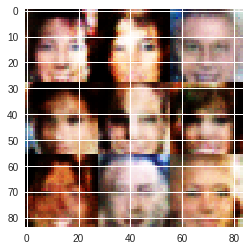

Epoch 1/1... Discriminator Loss: 0.3582... Generator Loss: 4.7696
Epoch 1/1... Discriminator Loss: 0.4553... Generator Loss: 5.5060
Epoch 1/1... Discriminator Loss: 0.4753... Generator Loss: 2.2743
Epoch 1/1... Discriminator Loss: 0.3646... Generator Loss: 3.8695
Epoch 1/1... Discriminator Loss: 0.3570... Generator Loss: 4.5998
Epoch 1/1... Discriminator Loss: 0.3333... Generator Loss: 7.9764
Epoch 1/1... Discriminator Loss: 0.5570... Generator Loss: 1.8745
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.3099
Epoch 1/1... Discriminator Loss: 0.3715... Generator Loss: 6.1374
Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 6.8142


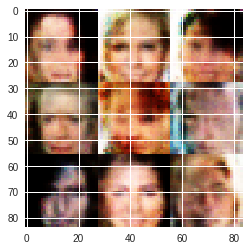

Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 8.9557
Epoch 1/1... Discriminator Loss: 0.4399... Generator Loss: 4.0859
Epoch 1/1... Discriminator Loss: 0.3536... Generator Loss: 5.5257
Epoch 1/1... Discriminator Loss: 0.5417... Generator Loss: 4.4787
Epoch 1/1... Discriminator Loss: 0.3441... Generator Loss: 5.5172
Epoch 1/1... Discriminator Loss: 0.3777... Generator Loss: 3.9293
Epoch 1/1... Discriminator Loss: 0.3508... Generator Loss: 4.2976
Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 3.2059
Epoch 1/1... Discriminator Loss: 0.3693... Generator Loss: 6.4677
Epoch 1/1... Discriminator Loss: 0.3350... Generator Loss: 7.9077


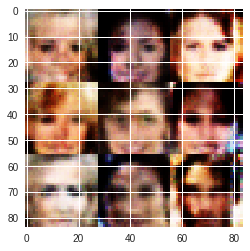

Epoch 1/1... Discriminator Loss: 0.3497... Generator Loss: 8.6358
Epoch 1/1... Discriminator Loss: 0.3491... Generator Loss: 4.3251
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 1.3776
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 1.9084
Epoch 1/1... Discriminator Loss: 0.3768... Generator Loss: 3.9984
Epoch 1/1... Discriminator Loss: 0.4055... Generator Loss: 2.9282
Epoch 1/1... Discriminator Loss: 0.4017... Generator Loss: 6.9386
Epoch 1/1... Discriminator Loss: 0.3601... Generator Loss: 4.4936
Epoch 1/1... Discriminator Loss: 0.3671... Generator Loss: 3.7817
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 7.0808


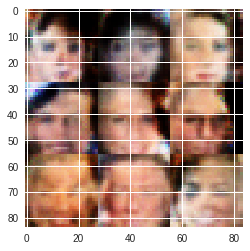

Epoch 1/1... Discriminator Loss: 0.3633... Generator Loss: 4.2144
Epoch 1/1... Discriminator Loss: 0.4986... Generator Loss: 2.1216
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 0.4034... Generator Loss: 3.2542
Epoch 1/1... Discriminator Loss: 0.3449... Generator Loss: 5.1953
Epoch 1/1... Discriminator Loss: 0.3628... Generator Loss: 6.4557
Epoch 1/1... Discriminator Loss: 0.3339... Generator Loss: 6.5581
Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 7.4587
Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 4.3655
Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 5.6662


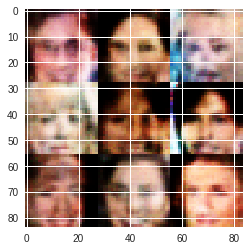

Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 2.4118
Epoch 1/1... Discriminator Loss: 0.3602... Generator Loss: 7.2920
Epoch 1/1... Discriminator Loss: 0.3447... Generator Loss: 5.4524
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 0.3385... Generator Loss: 6.6501
Epoch 1/1... Discriminator Loss: 0.3510... Generator Loss: 4.2911
Epoch 1/1... Discriminator Loss: 0.4001... Generator Loss: 3.2852
Epoch 1/1... Discriminator Loss: 0.3449... Generator Loss: 5.2943
Epoch 1/1... Discriminator Loss: 0.4079... Generator Loss: 2.8780
Epoch 1/1... Discriminator Loss: 0.5600... Generator Loss: 1.9845


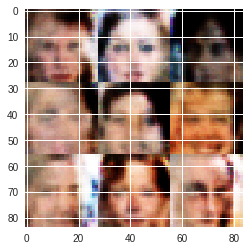

Epoch 1/1... Discriminator Loss: 0.4840... Generator Loss: 2.4416
Epoch 1/1... Discriminator Loss: 0.4340... Generator Loss: 2.6810
Epoch 1/1... Discriminator Loss: 0.4292... Generator Loss: 3.3619
Epoch 1/1... Discriminator Loss: 0.3514... Generator Loss: 4.8291
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 4.5510
Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 6.7327
Epoch 1/1... Discriminator Loss: 0.4125... Generator Loss: 2.7842
Epoch 1/1... Discriminator Loss: 1.8130... Generator Loss: 0.2936
Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 0.4422... Generator Loss: 2.4911


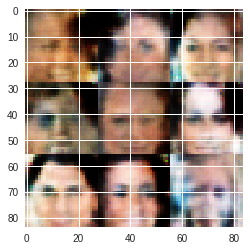

Epoch 1/1... Discriminator Loss: 0.4074... Generator Loss: 3.4371
Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 1.6864
Epoch 1/1... Discriminator Loss: 0.3513... Generator Loss: 5.2093
Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 1.0620
Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 3.1173
Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 4.8110
Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 3.1591
Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 2.3472
Epoch 1/1... Discriminator Loss: 0.3404... Generator Loss: 6.9422
Epoch 1/1... Discriminator Loss: 0.3414... Generator Loss: 5.3717


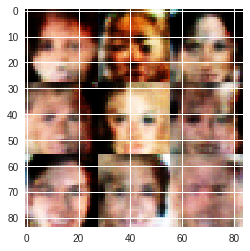

Epoch 1/1... Discriminator Loss: 0.3363... Generator Loss: 7.4402
Epoch 1/1... Discriminator Loss: 0.3633... Generator Loss: 6.0373
Epoch 1/1... Discriminator Loss: 0.5599... Generator Loss: 1.8461
Epoch 1/1... Discriminator Loss: 0.4448... Generator Loss: 2.7767
Epoch 1/1... Discriminator Loss: 0.4010... Generator Loss: 3.0382
Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 5.7901
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 2.1561
Epoch 1/1... Discriminator Loss: 0.4054... Generator Loss: 6.8488
Epoch 1/1... Discriminator Loss: 0.3533... Generator Loss: 4.0510
Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 3.1968


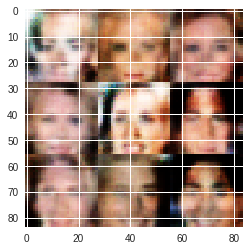

Epoch 1/1... Discriminator Loss: 0.3368... Generator Loss: 5.4497
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 0.4558... Generator Loss: 2.3797
Epoch 1/1... Discriminator Loss: 0.4596... Generator Loss: 2.5123
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 4.1252
Epoch 1/1... Discriminator Loss: 0.3577... Generator Loss: 4.2675
Epoch 1/1... Discriminator Loss: 0.5843... Generator Loss: 6.5496
Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 1.8321
Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 2.4484
Epoch 1/1... Discriminator Loss: 0.3524... Generator Loss: 4.5095


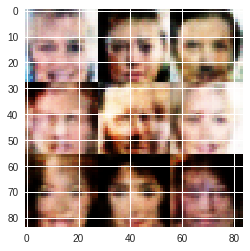

Epoch 1/1... Discriminator Loss: 0.6574... Generator Loss: 1.4055
Epoch 1/1... Discriminator Loss: 0.3378... Generator Loss: 5.8741
Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 1.2886
Epoch 1/1... Discriminator Loss: 0.3396... Generator Loss: 7.8328
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.0607
Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 3.2019
Epoch 1/1... Discriminator Loss: 0.4004... Generator Loss: 3.2571
Epoch 1/1... Discriminator Loss: 0.3491... Generator Loss: 4.7352
Epoch 1/1... Discriminator Loss: 0.5366... Generator Loss: 1.8637
Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 1.9479


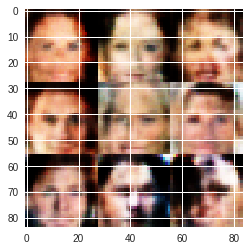

Epoch 1/1... Discriminator Loss: 0.3354... Generator Loss: 7.8054
Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 3.6233
Epoch 1/1... Discriminator Loss: 0.3447... Generator Loss: 5.9830
Epoch 1/1... Discriminator Loss: 0.3392... Generator Loss: 6.9128
Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 4.0281
Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 5.7804
Epoch 1/1... Discriminator Loss: 0.3594... Generator Loss: 8.6805
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 1.9950
Epoch 1/1... Discriminator Loss: 0.4436... Generator Loss: 3.7351
Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 2.4574


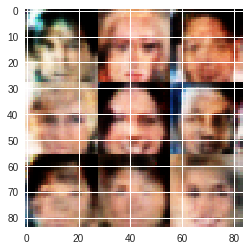

Epoch 1/1... Discriminator Loss: 0.3811... Generator Loss: 6.1857
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 6.1496
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 6.7699
Epoch 1/1... Discriminator Loss: 0.3475... Generator Loss: 4.6946
Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 4.9917
Epoch 1/1... Discriminator Loss: 0.3402... Generator Loss: 5.6604
Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 5.3294
Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 8.9404
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 2.7806
Epoch 1/1... Discriminator Loss: 0.3779... Generator Loss: 4.0067


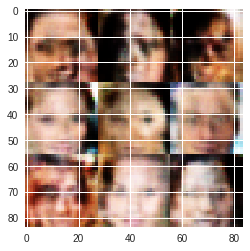

Epoch 1/1... Discriminator Loss: 0.3475... Generator Loss: 4.6550
Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 8.6988
Epoch 1/1... Discriminator Loss: 0.3879... Generator Loss: 3.3044
Epoch 1/1... Discriminator Loss: 0.4313... Generator Loss: 2.6328
Epoch 1/1... Discriminator Loss: 0.7125... Generator Loss: 1.3530
Epoch 1/1... Discriminator Loss: 0.3378... Generator Loss: 7.3448
Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 3.0601
Epoch 1/1... Discriminator Loss: 0.3397... Generator Loss: 5.9066
Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 7.4231
Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 6.3544


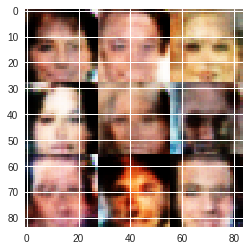

Epoch 1/1... Discriminator Loss: 0.4851... Generator Loss: 2.1039
Epoch 1/1... Discriminator Loss: 0.3380... Generator Loss: 6.4917
Epoch 1/1... Discriminator Loss: 0.4087... Generator Loss: 2.8577
Epoch 1/1... Discriminator Loss: 0.5175... Generator Loss: 1.9676
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 0.3326... Generator Loss: 8.1101
Epoch 1/1... Discriminator Loss: 0.3508... Generator Loss: 5.1637
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 5.0560
Epoch 1/1... Discriminator Loss: 0.3729... Generator Loss: 3.7467
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 5.4825


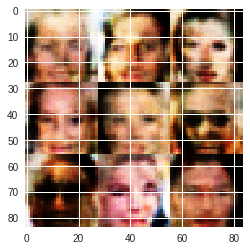

Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 9.2010
Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 1.7446
Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.4954
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 4.0480
Epoch 1/1... Discriminator Loss: 0.3476... Generator Loss: 5.1708
Epoch 1/1... Discriminator Loss: 0.3869... Generator Loss: 5.9718
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 0.9951
Epoch 1/1... Discriminator Loss: 0.3592... Generator Loss: 4.4888
Epoch 1/1... Discriminator Loss: 0.5814... Generator Loss: 5.4384
Epoch 1/1... Discriminator Loss: 0.8330... Generator Loss: 1.0964


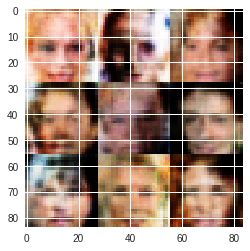

Epoch 1/1... Discriminator Loss: 0.4248... Generator Loss: 2.6732
Epoch 1/1... Discriminator Loss: 0.3730... Generator Loss: 3.5092
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 1.6939
Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 4.8529
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 3.0475
Epoch 1/1... Discriminator Loss: 0.3792... Generator Loss: 4.6751
Epoch 1/1... Discriminator Loss: 0.4082... Generator Loss: 2.9202
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 7.1347
Epoch 1/1... Discriminator Loss: 0.6800... Generator Loss: 1.6013


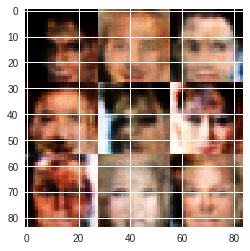

Epoch 1/1... Discriminator Loss: 0.4350... Generator Loss: 2.5875
Epoch 1/1... Discriminator Loss: 0.3529... Generator Loss: 5.2675
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 1.1416
Epoch 1/1... Discriminator Loss: 0.4262... Generator Loss: 3.8526
Epoch 1/1... Discriminator Loss: 0.4716... Generator Loss: 2.2447
Epoch 1/1... Discriminator Loss: 0.3676... Generator Loss: 3.9241
Epoch 1/1... Discriminator Loss: 0.3826... Generator Loss: 4.6792
Epoch 1/1... Discriminator Loss: 0.3701... Generator Loss: 4.3801
Epoch 1/1... Discriminator Loss: 0.3881... Generator Loss: 6.2084
Epoch 1/1... Discriminator Loss: 0.4322... Generator Loss: 2.5718


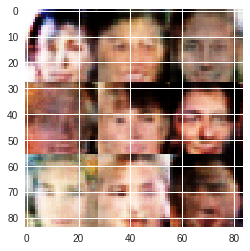

Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 3.1354
Epoch 1/1... Discriminator Loss: 0.3830... Generator Loss: 4.9732
Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 3.6721
Epoch 1/1... Discriminator Loss: 0.4328... Generator Loss: 3.5261
Epoch 1/1... Discriminator Loss: 0.3463... Generator Loss: 6.6720
Epoch 1/1... Discriminator Loss: 0.3407... Generator Loss: 6.5823
Epoch 1/1... Discriminator Loss: 0.3396... Generator Loss: 6.1199
Epoch 1/1... Discriminator Loss: 0.3406... Generator Loss: 6.3223
Epoch 1/1... Discriminator Loss: 0.5625... Generator Loss: 1.7063
Epoch 1/1... Discriminator Loss: 0.3736... Generator Loss: 7.2438


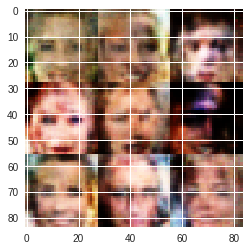

Epoch 1/1... Discriminator Loss: 0.3497... Generator Loss: 5.5726
Epoch 1/1... Discriminator Loss: 0.3612... Generator Loss: 3.8031
Epoch 1/1... Discriminator Loss: 0.4949... Generator Loss: 2.4467
Epoch 1/1... Discriminator Loss: 0.3445... Generator Loss: 6.1454
Epoch 1/1... Discriminator Loss: 0.3375... Generator Loss: 8.6458
Epoch 1/1... Discriminator Loss: 0.3648... Generator Loss: 3.9722
Epoch 1/1... Discriminator Loss: 0.3355... Generator Loss: 7.0998
Epoch 1/1... Discriminator Loss: 0.3484... Generator Loss: 4.6407
Epoch 1/1... Discriminator Loss: 0.3622... Generator Loss: 4.1675
Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 3.6071


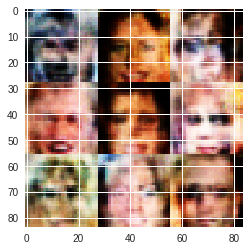

Epoch 1/1... Discriminator Loss: 0.5826... Generator Loss: 1.6571
Epoch 1/1... Discriminator Loss: 0.3435... Generator Loss: 5.3231
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 0.5562... Generator Loss: 2.1883
Epoch 1/1... Discriminator Loss: 0.5835... Generator Loss: 1.7143
Epoch 1/1... Discriminator Loss: 0.4695... Generator Loss: 2.4719
Epoch 1/1... Discriminator Loss: 0.3785... Generator Loss: 3.6238
Epoch 1/1... Discriminator Loss: 0.4813... Generator Loss: 2.1669
Epoch 1/1... Discriminator Loss: 0.4269... Generator Loss: 5.7471


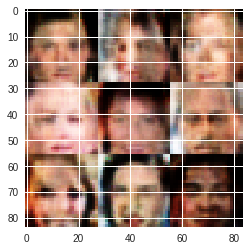

Epoch 1/1... Discriminator Loss: 0.3350... Generator Loss: 7.2227
Epoch 1/1... Discriminator Loss: 0.5052... Generator Loss: 2.0101
Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 6.5087
Epoch 1/1... Discriminator Loss: 0.3960... Generator Loss: 8.3393
Epoch 1/1... Discriminator Loss: 0.3343... Generator Loss: 8.7327
Epoch 1/1... Discriminator Loss: 0.3896... Generator Loss: 3.2278
Epoch 1/1... Discriminator Loss: 0.3407... Generator Loss: 5.1817
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 2.1728
Epoch 1/1... Discriminator Loss: 0.3456... Generator Loss: 5.5427
Epoch 1/1... Discriminator Loss: 0.4022... Generator Loss: 5.5693


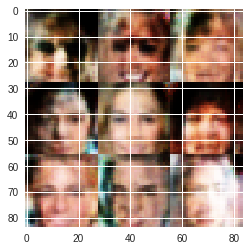

Epoch 1/1... Discriminator Loss: 0.3387... Generator Loss: 7.5279
Epoch 1/1... Discriminator Loss: 0.4553... Generator Loss: 2.3864
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.5030
Epoch 1/1... Discriminator Loss: 0.3605... Generator Loss: 4.0557
Epoch 1/1... Discriminator Loss: 0.3504... Generator Loss: 4.6614
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 3.6990
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 4.6154
Epoch 1/1... Discriminator Loss: 0.3769... Generator Loss: 3.6295
Epoch 1/1... Discriminator Loss: 0.3416... Generator Loss: 5.7373


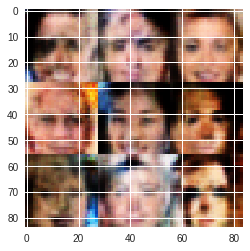

Epoch 1/1... Discriminator Loss: 0.4338... Generator Loss: 4.3569
Epoch 1/1... Discriminator Loss: 0.3601... Generator Loss: 3.8697
Epoch 1/1... Discriminator Loss: 0.3360... Generator Loss: 6.0807
Epoch 1/1... Discriminator Loss: 0.4164... Generator Loss: 2.7172
Epoch 1/1... Discriminator Loss: 0.3456... Generator Loss: 5.0582
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.4966


In [21]:
batch_size = 64
z_dim = 100
learning_rate =  0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.